# End-to-End Camera Calibration

see https://docs.google.com/document/d/1-ikSOxtrC4HLzd8xBdokjfMbbz0616eOBsco-bDk3os/edit

In [2]:
print("hello")

# this is from https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy

import numpy as np
import scipy.interpolate as interp

# auxiliary function for mesh generation
def gimme_mesh(n):
    minval = -1
    maxval =  1
    # produce an asymmetric shape in order to catch issues with transpositions
    return np.meshgrid(np.linspace(minval, maxval, n),
                       np.linspace(minval, maxval, n + 1))

# set up underlying test functions, vectorized
def fun_smooth(x, y):
    return np.cos(np.pi*x) * np.sin(np.pi*y)

def fun_evil(x, y):
    # watch out for singular origin; function has no unique limit there
    return np.where(x**2 + y**2 > 1e-10, x*y/(x**2+y**2), 0.5)

# sparse input mesh, 6x7 in shape
N_sparse = 6
x_sparse, y_sparse = gimme_mesh(N_sparse)
z_sparse_smooth = fun_smooth(x_sparse, y_sparse)
z_sparse_evil = fun_evil(x_sparse, y_sparse)

# scattered input points, 10^2 altogether (shape (100,))
N_scattered = 10
rng = np.random.default_rng()
x_scattered, y_scattered = rng.random((2, N_scattered**2))*2 - 1
z_scattered_smooth = fun_smooth(x_scattered, y_scattered)
z_scattered_evil = fun_evil(x_scattered, y_scattered)

# dense output mesh, 20x21 in shape
N_dense = 20
x_dense, y_dense = gimme_mesh(N_dense)

hello


In [3]:
import scipy.interpolate as interp

sparse_points = np.stack([x_sparse.ravel(), y_sparse.ravel()], -1)  # shape (N, 2) in 2d
dense_points = np.stack([x_dense.ravel(), y_dense.ravel()], -1)  # shape (N, 2) in 2d

zfun_smooth_rbf = interp.RBFInterpolator(sparse_points, z_sparse_smooth.ravel(),
                                         smoothing=0, kernel='cubic')  # explicit default smoothing=0 for interpolation
z_dense_smooth_rbf = zfun_smooth_rbf(dense_points).reshape(x_dense.shape)  # not really a function, but a callable class instance

zfun_evil_rbf = interp.RBFInterpolator(sparse_points, z_sparse_evil.ravel(),
                                       smoothing=0, kernel='cubic')  # explicit default smoothing=0 for interpolation
z_dense_evil_rbf = zfun_evil_rbf(dense_points).reshape(x_dense.shape)  # not really a function, but a callable class instance


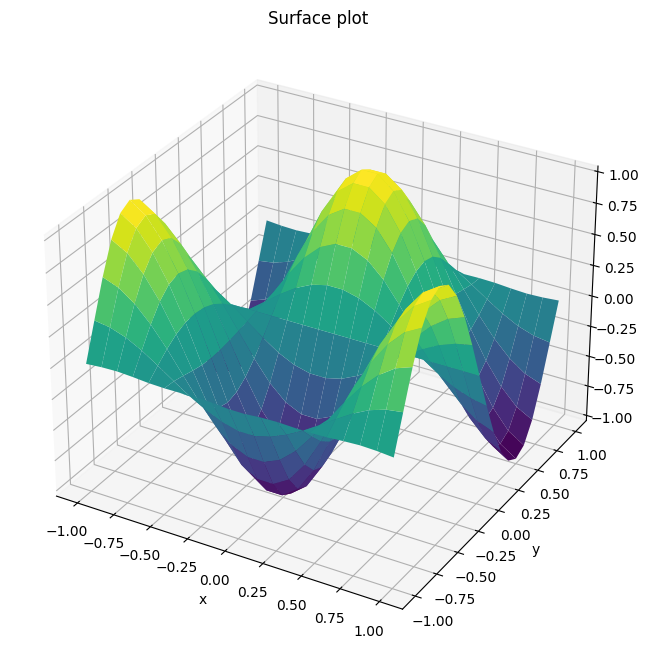

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8),dpi=100)
ax = plt.axes(projection='3d')

ax.plot_surface(x_dense, y_dense, z_dense_smooth_rbf ,cmap='viridis', edgecolor='none')
# ax.invert_xaxis()
ax.set_title('Surface plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [16]:


zfun_smooth_rbf = interp.LinearNDInterpolator(sparse_points, z_sparse_smooth.ravel())
z_dense_smooth_rbf = zfun_smooth_rbf(dense_points).reshape(x_dense.shape)  # not really a function, but a callable class instance

zfun_evil_rbf = interp.LinearNDInterpolator(sparse_points, z_sparse_evil.ravel()) 
z_dense_evil_rbf = zfun_evil_rbf(dense_points).reshape(x_dense.shape)  # not really a function, but a callable class instance

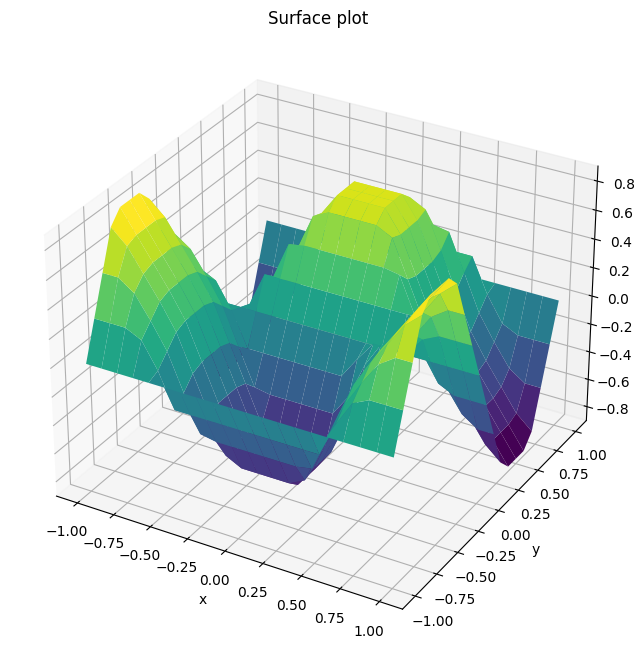

In [18]:
fig = plt.figure(figsize=(10,8),dpi=100)
ax = plt.axes(projection='3d')

ax.plot_surface(x_dense, y_dense, z_dense_smooth_rbf ,cmap='viridis', edgecolor='none')
# ax.invert_xaxis()
ax.set_title('Surface plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

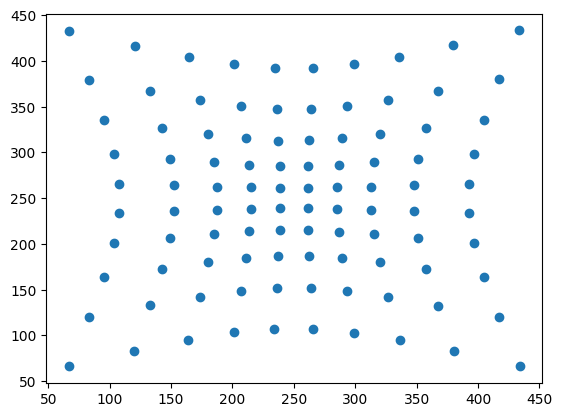

In [37]:
# this is from https://forum.opencv.org/t/understanding-the-functions-projectpoints-and-undistortpoints/10847

import cv2

# calibration matrix
K = np.array([
    [500.0, 0.0, 250.0], 
    [0.0, 500.0, 250.0],
    [0.0, 0.0, 1.0]
    ])

# distortion coefficients (k1, k2, p1, p2, k3)
# A LOT of distortion, in order to see it work.
distCoeffs = np.array([10.5, -0.95, -0.005, 0.0025,  1.16])

# Coordinates of points in plane, representing a pointcloud in camera reference (c)
# plane
H, W = 1, 1
X, Y = np.meshgrid(np.linspace(-W, W, 10), np.linspace(-H, H, 10))
X, Y = X.reshape(1, -1), Y.reshape(1, -1)
# add depth. Pointcloud of n points represented as a (3, n) array:
Z = 5
P_c = np.concatenate((X, Y, Z * np.ones_like(X)), axis=0)

# project points, including with lens distortion 
U_dist, _ = cv2.projectPoints(P_c, np.zeros((3,)), np.zeros((3,)), K, distCoeffs)
# projections as (2, n) array.
U_dist = U_dist[:, 0].T
# U_dist[0]
plt.scatter(U_dist[0],U_dist[1])
plt.show()
